In [ ]:
# Source
# https://github.com/sktime/sktime/blob/main/examples/window_splitters.ipynb

In [ ]:
!pip install sktime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.2/127.2 kB 13.9 MB/s eta 0:00:00


# Window Splitters in Sktime

In this notebook we describe the window splitters included in the [`sktime.split`](https://github.com/sktime/sktime/blob/main/sktime/split/__init__.py) module. These splitters can be combined with `ForecastingGridSearchCV` for model selection (see [forecasting notebook](https://github.com/sktime/sktime/blob/main/examples/01_forecasting.ipynb)).

**Remark:** It is important to emphasize that for cross-validation in time series we can not randomly shuffle the data as we would be leaking information.

**References:**
- [Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)
- [Cross-validation for time series](https://robjhyndman.com/hyndsight/tscv/)

## Preliminaries

In [ ]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import (
    CutoffSplitter,
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series

In [ ]:
def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows"""

    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = [(leg[:2]) for leg in ax.get_legend_handles_labels()]
    ax.legend(handles, labels);

## Data

We use a fraction of the Box-Jenkins univariate airline data set, which shows the number of international airline passengers per month from 1949 - 1960.

In [ ]:
# We are interested on a portion of the total data set.
# (for visualisatiion purposes)
y = load_airline().iloc[:30]
y.head()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
Freq: M, Name: Number of airline passengers, dtype: float64

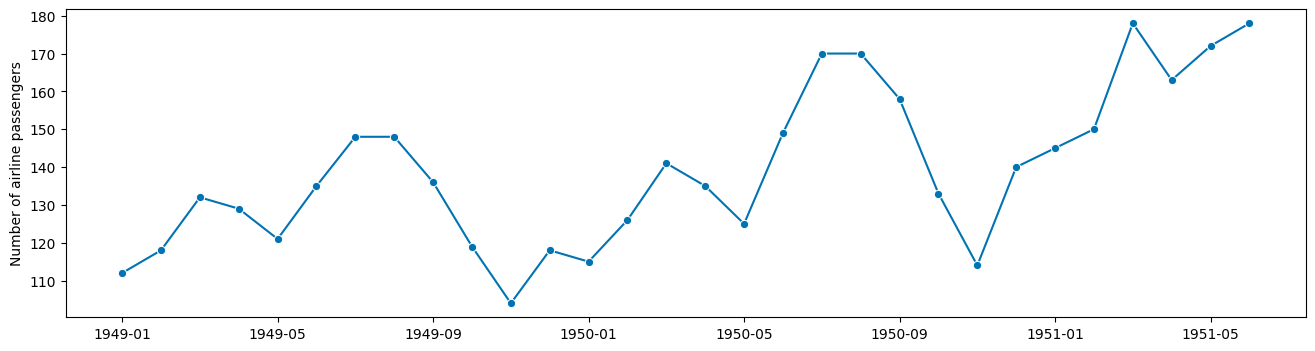

In [ ]:
fig, ax = plot_series(y)

## Visualizing temporal cross-validation window splitters

Now we describe each of the splitters.  

### A single train-test split using `temporal_train_test_split`

This one splits the data into a traininig and test sets. You can either (i) set the size of the training or test set or (ii) use a forecasting horizon.

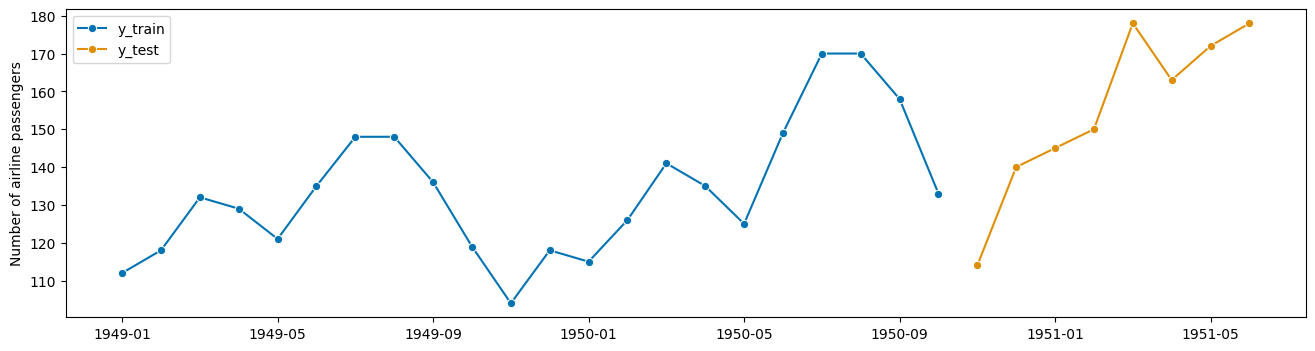

In [ ]:
# setting test set size
y_train, y_test = temporal_train_test_split(y=y, test_size=0.25)
fig, ax = plot_series(y_train, y_test, labels=["y_train", "y_test"])

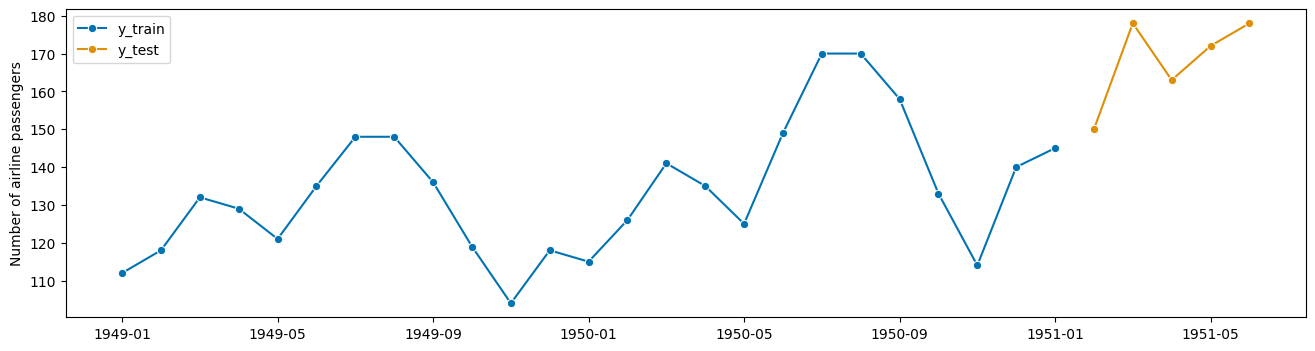

In [ ]:
# using forecasting horizon
fh = ForecastingHorizon([1, 2, 3, 4, 5])
y_train, y_test = temporal_train_test_split(y, fh=fh)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);

### Single split using `SingleWindowSplitter`

This class splits the time series once into a training and test window. Note that this is very similar to `temporal_train_test_split`.

Let us define the parameters of our fold:

In [ ]:
# set splitter parameters
window_length = 5
fh = ForecastingHorizon([1, 2, 3])

In [ ]:
cv = SingleWindowSplitter(window_length=window_length, fh=fh)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 1


Let us plot the unique fold generated. First we define some helper functions:

In [ ]:
def get_windows(y, cv):
    """Generate windows"""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

Now we generate the plot:

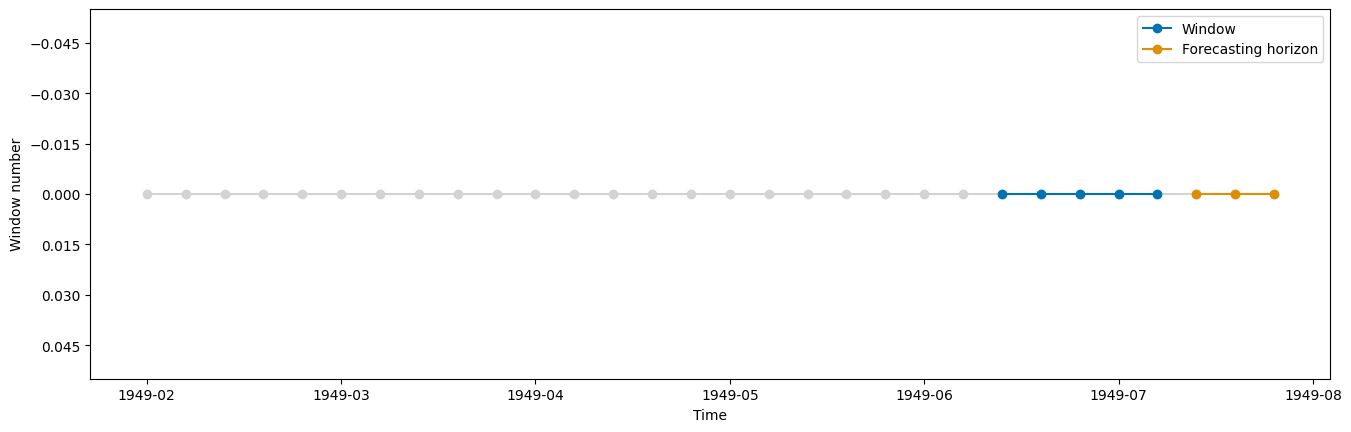

In [ ]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [ ]:
test_windows

[array([27, 28, 29])]

In [ ]:
train_windows

[array([22, 23, 24, 25, 26])]

### Sliding windows using `SlidingWindowSplitter`

This splitter generates folds which move with time. The length of the training and test sets for each fold remains constant.

In [ ]:
cv = SlidingWindowSplitter(window_length=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 23


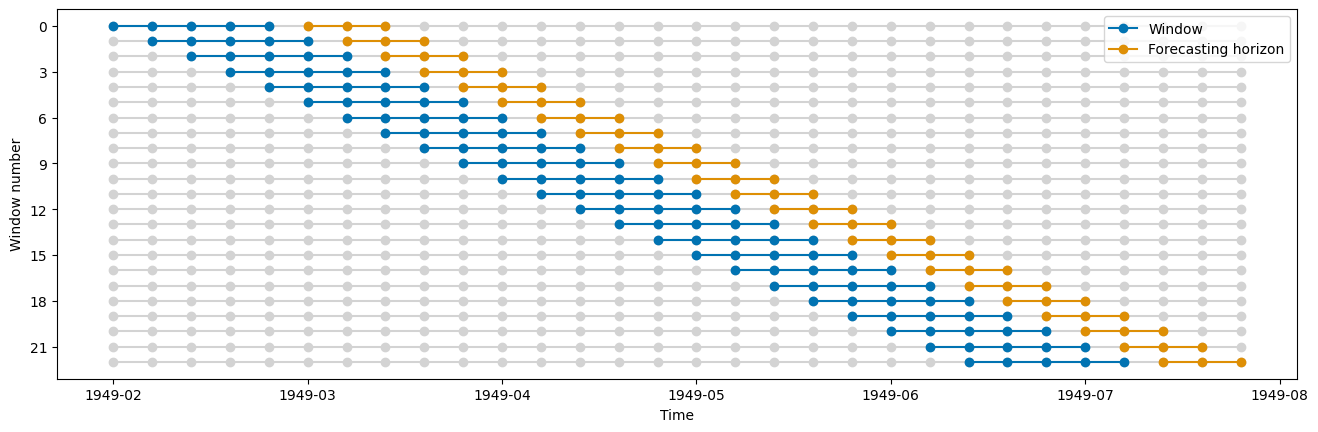

In [ ]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### Sliding windows using `SlidingWindowSplitter` with an initial window

This splitter generates folds which move with time. The length of the training and test sets for each fold remains constant.

In [ ]:
cv = SlidingWindowSplitter(window_length=window_length, fh=fh, initial_window=10)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 18


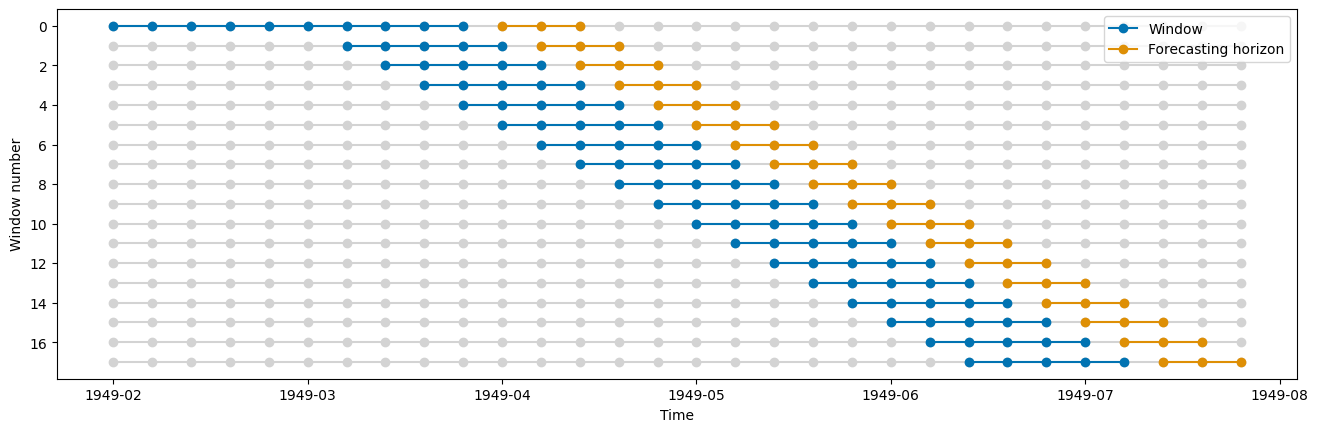

In [ ]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### Expanding windows using `ExpandingWindowSplitter`

This splitter generates folds which move with time. The length of the training set each fold grows while test sets for each fold remains constant.

In [ ]:
cv = ExpandingWindowSplitter(initial_window=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 23


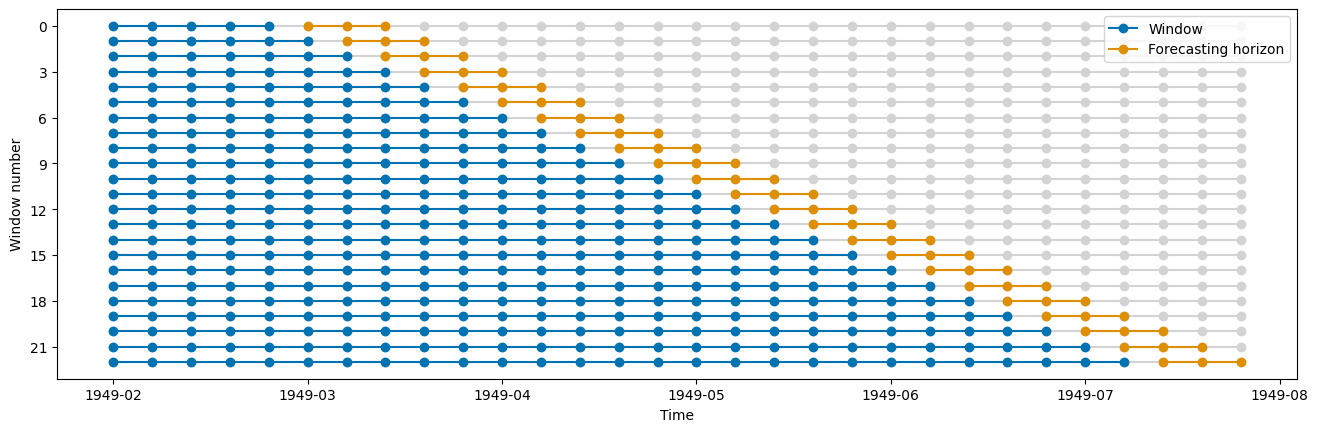

In [ ]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### Multiple splits at specific cutoff values - `CutoffSplitter`

With this splitter we can manually select the cutoff points.

In [ ]:
# Specify cutoff points (by array index).
cutoffs = np.array([10, 13, 15, 25])

cv = CutoffSplitter(cutoffs=cutoffs, window_length=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

Number of Folds = 4


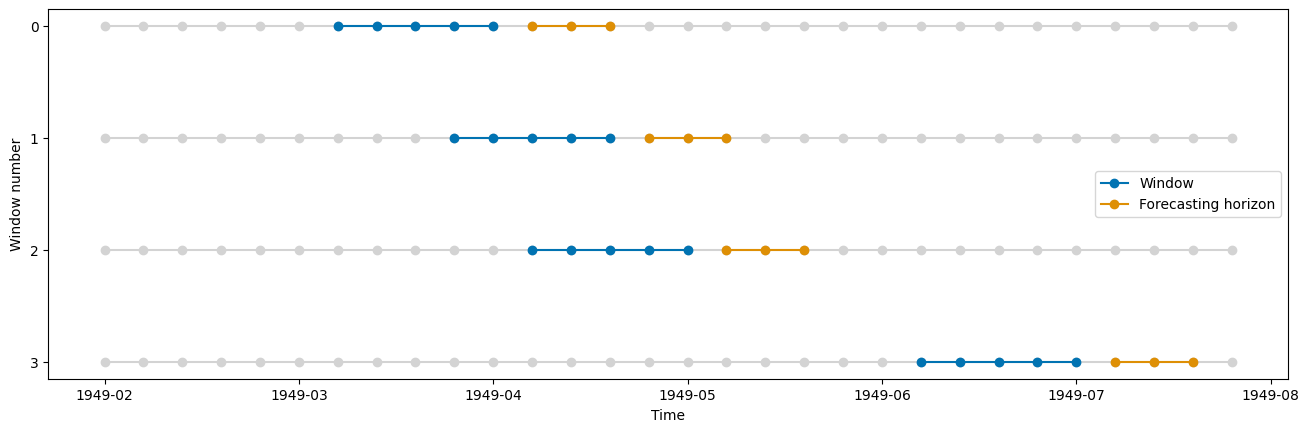

In [ ]:
train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [ ]:
train_windows

[array([ 6,  7,  8,  9, 10]),
 array([ 9, 10, 11, 12, 13]),
 array([11, 12, 13, 14, 15]),
 array([21, 22, 23, 24, 25])]

In [ ]:
test_windows

[array([11, 12, 13]),
 array([14, 15, 16]),
 array([16, 17, 18]),
 array([26, 27, 28])]

## Grid Search in SkTime

In [ ]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV, SlidingWindowSplitter
from sktime.datasets import load_airline

air = load_airline()
air_train, air_test = temporal_train_test_split(y=air, test_size=0.25)

forecaster = ExponentialSmoothing()
param_grid = {"sp": [6, 12], 'seasonal': ['add', 'mul']}

cv = SlidingWindowSplitter(initial_window=30, window_length=25, fh=1)

gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)
gscv.fit(air_train)

ForecastingGridSearchCV(cv=SlidingWindowSplitter(initial_window=30,
                                                 window_length=25),
                        forecaster=ExponentialSmoothing(),
                        param_grid={'seasonal': ['add', 'mul'], 'sp': [6, 12]})

In [ ]:
gscv.best_params_
#     gscv.best_forecaster_: An instance of the best forecaster with the optimal hyperparameters

{'seasonal': 'add', 'sp': 12}

In [ ]:
fcaster = gscv.best_forecaster_
fcaster

ExponentialSmoothing(seasonal='add', sp=12)

In [ ]:
fcaster.predict(range(1, 13))

1958-01    352.794287
1958-02    340.779205
1958-03    390.534292
1958-04    380.852651
1958-05    385.294533
1958-06    443.041050
1958-07    475.809369
1958-08    463.407959
1958-09    395.094296
1958-10    338.567075
1958-11    300.289954
1958-12    343.731475
Freq: M, Name: Number of airline passengers, dtype: float64

## Scikit-Learn CV Splitters

> A non-estimator family of classes used to split a dataset into a sequence of train and test portions
(see Cross-validation: evaluating estimator performance), by providing split and get_n_splits methods.
Note that unlike estimators, these do not have fit methods and do not provide set_params or get_params.
Parameter validation may be performed in __init__.
>
> Source: [Scikit-Learn's Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

### Scikit-Learn `TimeSeriesSplit`

Number of Folds = 3


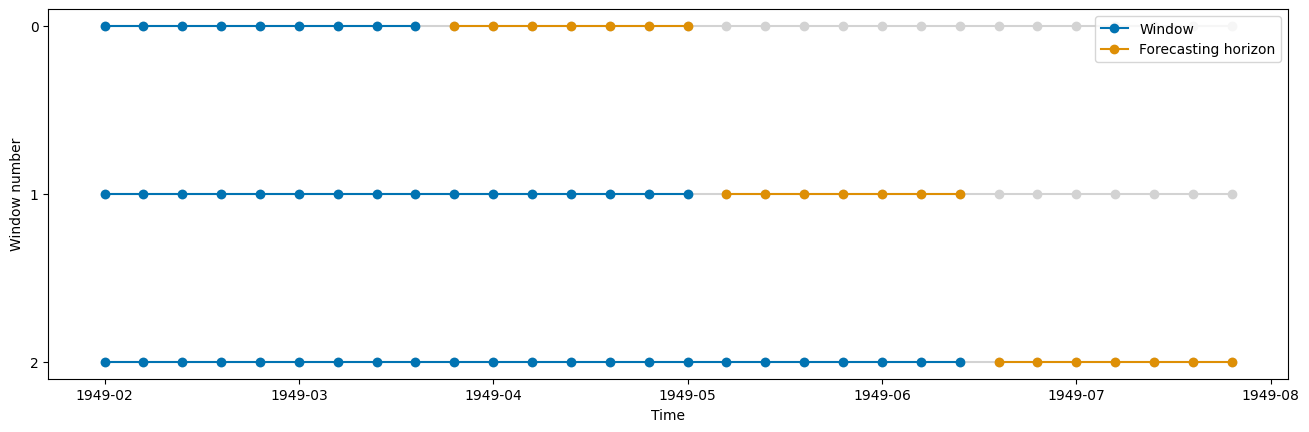

In [ ]:
# https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=3)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

## DARTS

In [ ]:
# https://unit8co.github.io/darts/generated_api/darts.utils.model_selection.html
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.4/819.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.7/120.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2

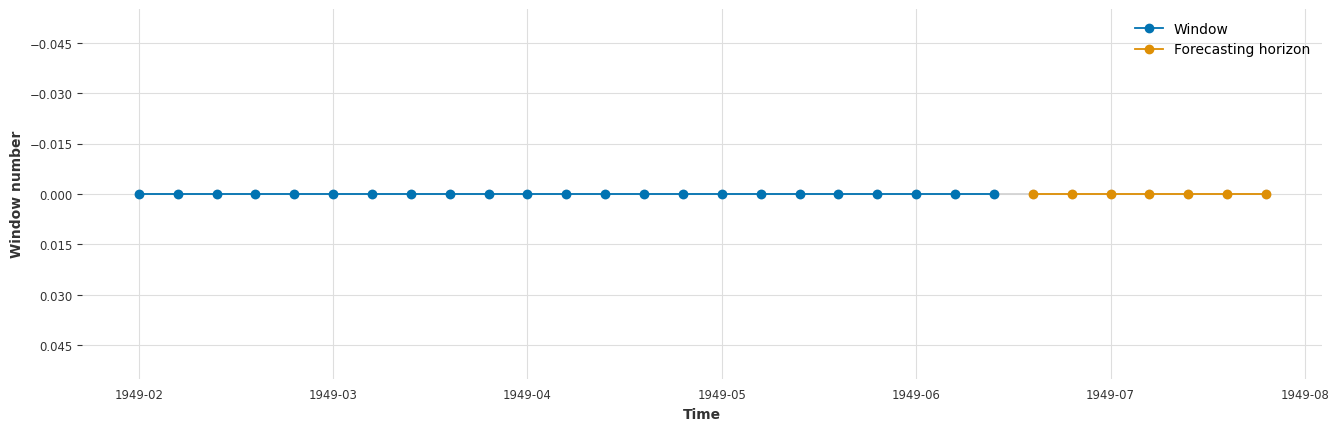

In [ ]:
from darts.utils.model_selection import train_test_split

train, test = train_test_split(y.reset_index(), test_size=0.25)

train_windows = [train.index]
test_windows = [test.index]
plot_windows(y, train_windows, test_windows)

## Backtesting

> Backtesting is a term used in modeling to refer to testing a predictive model on historical data. Backtesting involves moving backward in time, step-by-step, in as many stages as is necessary. Therefore, it is a special type of cross-validation applied to previous period(s).
>
> **Backtesting with refit and increasing training size (fixed origin)**
>
> The model is trained each time before making predictions. With this configuration, the model uses all the data available so far. It is a variation of the standard cross-validation but, instead of making a random distribution of the observations, the training set increases sequentially, maintaining the temporal order of the data.
>
> <p align="center"><img src="https://github.com/JoaquinAmatRodrigo/cienciadedatos.net/blob/main/images/diagram-backtesting-refit.png?raw=true" style="width: 500px;"/></p>
>
> <center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and retraining at each iteration.</i></font></center>
>
> **Backtesting with refit and fixed training size (rolling origin)**
>
> A technique similar to the previous one but, in this case, the forecast origin rolls forward, therefore, the size of training remains constant. This is also known as time series cross-validation or walk-forward validation.
>
> <p align="center"><img src="https://github.com/JoaquinAmatRodrigo/cienciadedatos.net/blob/main/images/diagram-backtesting-refit-fixed-train-size.png?raw=true" style="width: 500px;"/></p>
>
> <center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and a training set of constant size.</i></font></center>
>
> **Backtesting without refit**
>
> After an initial train, the model is used sequentially without updating it and following the temporal order of the data. This strategy has the advantage of being much faster since the model is trained only once. However, the model does not incorporate the latest data available, so it may lose predictive capacity over time.
>
> <p align="center"><img src="https://github.com/JoaquinAmatRodrigo/cienciadedatos.net/blob/main/images/diagram-backtesting-no-refit.png?raw=true" style="width: 500px;"/></p>
>
> <center><font size='2.5'> <i>Time series backtesting diagram with an initial training size of 10 observations, a prediction horizon of 3 steps, and no retraining at each iteration.</i></font></center>
<br>
>
> The **skforecast** library has the mentioned [backtesting strategies](https://joaquinamatrodrigo.github.io/skforecast/latest/user_guides/backtesting.html#backtesting) implemented. Regardless of which one is used, it is important not to include test data in the search process to avoid overfitting problems.
>
> For this example, a **backtesting with refit** strategy is followed. Internally, the process that the function applies is:
>
> + In the first iteration, the model is trained with the observations selected for the initial training (in this case, 87). Then, the next 36 observations are used to validate the predictions of this first model.
>
> + In the second iteration, the model is retrained by adding, to the initial training set, the previous 36 validation observations (87 + 36). In the same way, the next 36 observations are established as the new validation set.
>
> + This process is repeated until all available observations are used. Following this strategy, the training set increases in each iteration with as many observations as steps are being predicted.
>
> Source: [SkForecast's documentation](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html)

### `backtest()` method in DARTS

> Compute error values that the model would have produced when used on (potentially multiple) series.
>
> If historical_forecasts are provided, the metric (given by the metric function) is evaluated directly on the forecast and the actual values. Otherwise, it repeatedly builds a training set: either expanding from the beginning of series or moving with a fixed length train_length. It trains the current model on the training set, emits a forecast of length equal to forecast_horizon, and then moves the end of the training set forward by stride time steps. The metric is then evaluated on the forecast and the actual values. Finally, the method returns a reduction (the mean by default) of all these metric scores.
>
> By default, this method uses each historical forecast (whole) to compute error scores. If last_points_only is set to True, it will use only the last point of each historical forecast. In this case, no reduction is used.
>
> By default, this method always re-trains the models on the entire available history, corresponding to an expanding window strategy. If retrain is set to False (useful for models for which training might be time-consuming, such as deep learning models), the trained model will be used directly to emit the forecasts.
>
> Source: [DARTS' documentation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html?highlight=gridsearch#darts.models.forecasting.regression_model.RegressionModel.backtest)

#### Arguments
- `start`: the first point at which a prediction is computed (`initial_window` in SkTime)
- `train_length`: if None, it takes all available time steps up until prediction time (i.e. *expanding window*), otherwise the moving window strategy is used (i.e. *sliding window*)
  - if set, it is equivalent to `window_length` in SkTime's `SlidingWindowSplitter`
- `forecast_horizon`: the forecast horizon for the point predictions (`fh` in SkTime)
- `stride`: the number of time steps between two consecutive predictions (`step_length` in SkTime)

In [ ]:
from darts.datasets import AirPassengersDataset
air = AirPassengersDataset().load()

In [ ]:
# train_length set
# start=None, forecasting_horizon=12, stride=1, train_length=30
cv = SlidingWindowSplitter(window_length=30, fh=12, step_length=1)
n_splits = cv.get_n_splits(air.values())
print(f"Number of Folds = {n_splits}")

# start=None, forecasting_horizon=12, stride=3, train_length=30
cv = SlidingWindowSplitter(window_length=30, fh=12, step_length=3)
n_splits = cv.get_n_splits(air.values())
print(f"Number of Folds = {n_splits}")

# start=72, forecasting_horizon=12, stride=3, train_length=30
cv = SlidingWindowSplitter(window_length=30, fh=12, step_length=3, initial_window=72)
n_splits = cv.get_n_splits(air.values())
print(f"Number of Folds = {n_splits}")

# train_length = None
# start=72, forecasting_horizon=12, stride=1, train_length=None
cv = ExpandingWindowSplitter(initial_window=72, fh=12)
n_splits = cv.get_n_splits(air.values())
print(f"Number of Folds = {n_splits}")

# start=None, forecasting_horizon=12, stride=1, train_length=None
cv = ExpandingWindowSplitter(initial_window=24, fh=12, step_length=1)
n_splits = cv.get_n_splits(air.values())
print(f"Number of Folds = {n_splits}")

Number of Folds = 103
Number of Folds = 35
Number of Folds = 21
Number of Folds = 61
Number of Folds = 109


### `gridsearch()` method in DARTS
>
> This function has 3 modes of operation: Expanding window mode, split mode and fitted value mode. The three modes of operation evaluate every possible combination of hyper-parameter values provided in the parameters dictionary by instantiating the model_class subclass of ForecastingModel with each combination, and returning the best-performing model with regard to the metric function. The metric function is expected to return an error value, thus the model resulting in the smallest metric output will be chosen.
>
> The relationship of the training data and test data depends on the mode of operation.
>
> Expanding window mode (activated when forecast_horizon is passed): For every hyperparameter combination, the model is repeatedly trained and evaluated on different splits of series. This process is accomplished by using the backtest() function as a subroutine to produce historic forecasts starting from start that are compared against the ground truth values of series. Note that the model is retrained for every single prediction, thus this mode is slower.
>
> Split window mode (activated when val_series is passed): This mode will be used when the val_series argument is passed. For every hyper-parameter combination, the model is trained on series and evaluated on val_series.
>
> Fitted value mode (activated when use_fitted_values is set to True): For every hyper-parameter combination, the model is trained on series and evaluated on the resulting fitted values. Not all models have fitted values, and this method raises an error if the model doesn’t have a fitted_values member. The fitted values are the result of the fit of the model on series. Comparing with the fitted values can be a quick way to assess the model, but one cannot see if the model is overfitting the series.
>
> Source: [DARTS' documentation](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.regression_model.html?highlight=gridsearch#darts.models.forecasting.regression_model.RegressionModel.gridsearch)

- `forecast_horizon`: triggers *expanding window mode*
- `start`: only used in *expanding window mode*, the first point at which a prediction is computed
- `val_series`: triggers *split window mode*, an instance of `TimeSeries` used for validation, it must start right after the end of the training series
- `use_fitted_values`: triggers *fitted value mode*, it computes evaluation metrics using the training data

## TSCV

In [ ]:
# https://github.com/WenjieZ/TSCV

In [ ]:
!pip install tscv

In [ ]:
from tscv import (
    GapLeavePOut,
    GapKFold,
    GapRollForward,
    gap_train_test_split
)

### `gap_train_test_split()`

![](https://tscv.readthedocs.io/en/latest/_images/gap_train_test_split.svg)
Source: [TSCV docs](https://tscv.readthedocs.io/en/latest/tutorial/train_test_split.html)

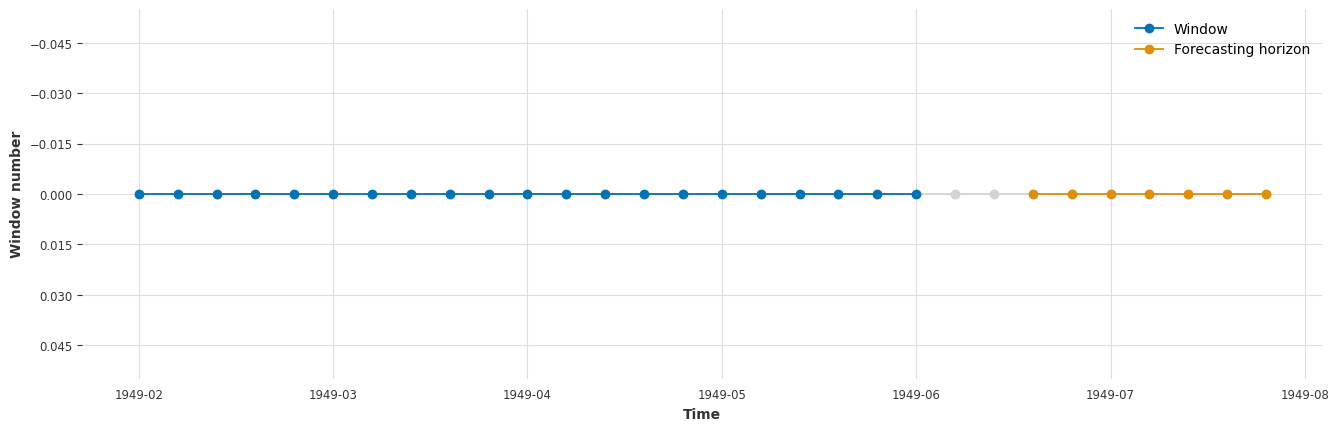

In [ ]:
train, test = gap_train_test_split(y.reset_index(), test_size=.25, gap_size=2)
train_windows = [train.index]
test_windows = [test.index]
plot_windows(y, train_windows, test_windows)

### `GapLeavePOut`

![](https://tscv.readthedocs.io/en/latest/_images/gap_leave_p_out.svg)
Source: [TSCV docs](https://tscv.readthedocs.io/en/latest/tutorial/leave_p_out.html)

Number of Folds = 21


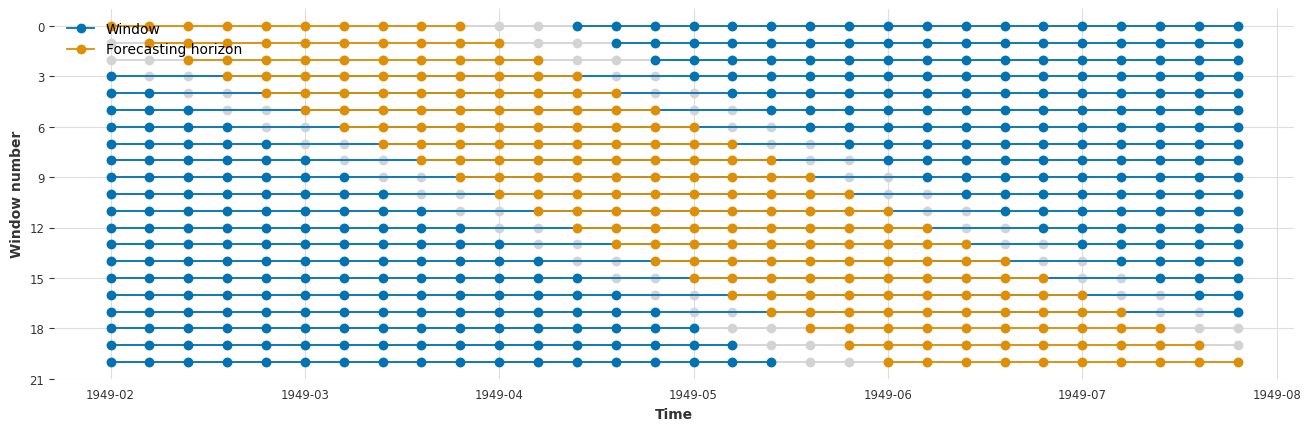

In [ ]:
cv = GapLeavePOut(p=10, gap_before=2, gap_after=2)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### `GapKFold`

![](https://tscv.readthedocs.io/en/latest/_images/gap_k-fold.svg)
Source: [TSCV docs](https://tscv.readthedocs.io/en/latest/tutorial/k_fold.html)

Number of Folds = 5


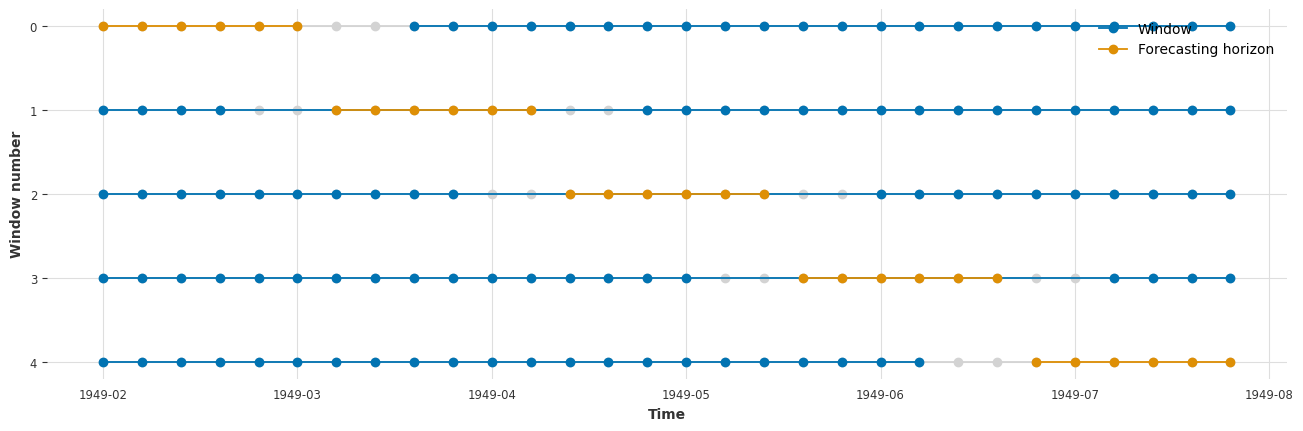

In [ ]:
cv = GapKFold(n_splits=5, gap_before=2, gap_after=2)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

### `GapRollForward`

![](https://tscv.readthedocs.io/en/latest/_images/gap_walk_forward.svg)
Source: [TSCV docs](https://tscv.readthedocs.io/en/latest/tutorial/roll_forward.html)

Number of Folds = 6


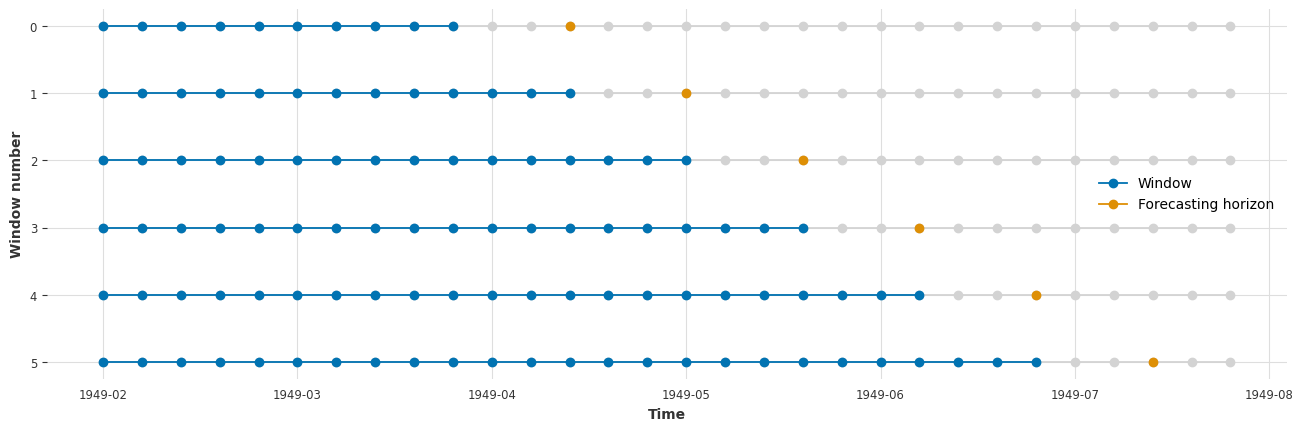

In [ ]:
cv = GapRollForward(min_train_size=10, gap_size=2, roll_size=3)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

In [ ]:
# https://towardsdatascience.com/dont-use-k-fold-validation-for-time-series-forecasting-30b724aaea64
# https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9